**Wymagane pakiety:**
- `matplotlib`

# Inicjalizacja

In [1]:
from enum import Enum
import math, random

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as anim

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["lines.marker"] = ""
plt.rcParams["lines.markersize"] = 5

# Funkcje pomocnicze

In [2]:
EPSILON = 10 ** -10

# calculates 3x3 det of 3 points, used to check wheter the p2 is CW/CCW/COLL to the p0-p1 segment
def det3(p0, p1, p2):
    return p0[0] * p1[1] + p1[0] * p2[1] + p2[0] * p0[1] - p2[0] * p1[1] - p1[0] * p0[1] - p0[0] * p2[1]

# checks whether p is inside the circle circumscribed on triangle t1, t2, t3
# t1, t2, t3 must be given in CCW order
def insideCircle(t1, t2, t3, p):
    ax, ay = t1
    bx, by = t2
    cx, cy = t3
    dx, dy = p
    
    m = [
        [ax - dx, ay - dy, (ax - dx) ** 2 + (ay - dy) ** 2],
        [bx - dx, by - dy, (bx - dx) ** 2 + (by - dy) ** 2],
        [cx - dx, cy - dy, (cx - dx) ** 2 + (cy - dy) ** 2]
    ]
    
    det =   m[0][0] * m[1][1] * m[2][2] \
          + m[1][0] * m[2][1] * m[0][2] \
          + m[2][0] * m[0][1] * m[1][2] \
          - m[2][0] * m[1][1] * m[0][2] \
          - m[1][0] * m[0][1] * m[2][2] \
          - m[0][0] * m[2][1] * m[1][2]
    
    return det > EPSILON

# Klasy pomocnicze

In [3]:
# instances of Point contain references to other points
# by the triangles map (K is other point, V is the triangle gived edge is part of)
# any 2 points are connected with max 2 triangles
class Point:
    def __init__(self, x=None, y=None):
        self.x = x
        self.y = y
        # holds connections to other points by triangles
        # every key of this map holds a set with 2 triangles max
        self.triangles = {}
        self.isArbL = False
        self.isArbR = False
    
    # add a triangle to this point, make connections to other points
    def addTriangle(self, triangle):
        connectedWith = triangle.points - {self}
        
        for point in connectedWith:
            if point in self.triangles:
                self.triangles[point].add(triangle)
            else:
                self.triangles[point] = {triangle}
        
    # remove a triangle from this point, break connections to other points
    def removeTriangle(self, triangle):
        connectedWith = triangle.points - {self}
        
        for point in connectedWith:
            self.triangles[point].remove(triangle)
            
            if len(self.triangles[point]) == 0:
                del self.triangles[point]
    
    # get x/y coordinates of the point
    def asPair(self):
        return (self.x, self.y)
    
    def isArb(self):
        return self.isArbL or self.isArbR
    
    # check whether this point is inside the triangle
    # 
    # a point is inside a triangle, when the point lies
    # "on the same side" of all half-planes created by sides of the triangle
    # (given that the triangle might be represented by
    # points in CW or CCW order), or when the point lies
    # on one of the triangle's sides
    def liesIn(self, triangle):
        # used to check the edge case, when the point lies on the side of a triangle
        def onSegment(s1, s2, p):
            xi, yi = s1
            xj, yj = s2
            xk, yk = p
            
            return min(xi, xj) <= xk <= max(xi, xj) and min(yi, yj) <= yk <= max(yi, yj)
        
        arbitrary = set(filter(lambda point: point.isArb(), triangle.points))
        
        if len(arbitrary) == 2:
            nonArbitrary, = triangle.points - arbitrary
            return self.y <= nonArbitrary.y
        elif len(arbitrary) == 1:
            arb, = arbitrary
            
            n1, n2 = triangle.points - arbitrary
            if n1.y > n2.y:
                n1, n2 = n2, n1
                
            side = Dir.getDir(n1.asPair(), n2.asPair(), self.asPair())
            
            return n1.y <= self.y <= n2.y and (side == Dir.COLL or (side == Dir.CCW and arb.isArbL) or (side == Dir.CW and arb.isArbR))
        else:
            t1, t2, t3 = [point.asPair() for point in triangle.points]

            p = self.asPair()

            d1 = Dir.getDir(t1, t2, p)
            d2 = Dir.getDir(t2, t3, p)
            d3 = Dir.getDir(t3, t1, p)

            if d1 == d2 == d3:
                return True

            if d1 == Dir.COLL and onSegment(t1, t2, p):
                return True
            if d2 == Dir.COLL and onSegment(t2, t3, p):
                return True
            if d3 == Dir.COLL and onSegment(t3, t1, p):
                return True

            return False

# instaces of Triangle are used to build the triangle tree
# and provide quick access to triangles along connected points
# of the triangulation
class Triangle:
    def __init__(self, p1, p2, p3):
        self.points = {p1, p2, p3}
        self.children = []
    
    # make connections between points the triangle is made of
    def add(self):
        for point in self.points:
            point.addTriangle(self)
    
    # break connections between points the triangle is made of
    def remove(self):
        for point in self.points:
            point.removeTriangle(self)
        
    # a triangle is not a leaf, when it's not in the triangulation
    # anymore. It's a dead instance used only to build the triangle search tree
    def isLeaf(self):
        return len(self.children) == 0
    
class Dir(Enum):
    CW, COLL, CCW = range(-1, 2)
    
    def getDir(p0, p1, p2):
        det = det3(p0, p1, p2)

        if det < -EPSILON:
            return Dir.CW
        elif det <= EPSILON:
            return Dir.COLL
        else:
            return Dir.CCW

# Podfunkcje implementacji algorytmu triangulacji

In [4]:
# find the triangle the given points lies in
# it returns a list, as one point might lie
# on two triangles at the same time
def triangleSearch(triangleTree, point, visited=None):
    # further calls of this metod maintain a set of triangles
    # already visited, to prevent returning duplicates
    # it's possible as there are multiple paths to same triangles
    if visited is None:
        visited = set()
        
    visited.add(triangleTree)
    
    if point.liesIn(triangleTree):
        
        if triangleTree.isLeaf():
            return [triangleTree]
        else:
            result = []
            
            for triangle in triangleTree.children:
                if triangle not in visited:
                    result += triangleSearch(triangle, point, visited)
                
            return result
    else:
        return []

# checks whether the opposite point of two coincident
# triangles is legal, i. e. lies outside the circle
# circumscribed on the first triangle
def isLegal(triangle, adjFreePoint):
    if adjFreePoint.isArb():
        return True
    
    arbitrary = set(filter(lambda point: point.isArb(), triangle.points))
    
    if len(arbitrary) == 2:
        nonArbitrary, = triangle.points - arbitrary
        return adjFreePoint.y >= nonArbitrary.y
    elif len(arbitrary) == 1:
        arb, = arbitrary

        n1, n2 = triangle.points - arbitrary
        if n1.y > n2.y:
            n1, n2 = n2, n1

        side = Dir.getDir(n1.asPair(), n2.asPair(), adjFreePoint.asPair())
        
        return side == Dir.COLL or (side == Dir.CW and arb.isArbL) or (side == Dir.CCW and arb.isArbR)
    else:
        t1, t2, t3 = [point.asPair() for point in triangle.points]

        # insideCircle method requires triangle points to be in CCW order
        # in case it's the opposite, we have to swap any 2 points
        if Dir.getDir(t1, t2, t3) == Dir.CW:
            t1, t2 = t2, t1

        return not insideCircle(t1, t2, t3, adjFreePoint.asPair())

# legalizes edges/triangles over edge opposite to freePoint
def legalizeEdge(triangle, freePoint):
    # get the edge opposite to freePoints, which will be legalized
    p1, p2 = triangle.points - {freePoint}
    
    # find coincident triangle over edge
    # this loop has max 2 iterations, as any 2 points
    # are connected together with 2 triangles at most
    for adjTriangle in p1.triangles[p2]:
        if adjTriangle != triangle:
            
            adjFreePoint, = adjTriangle.points - {p1, p2}

            if not isLegal(triangle, adjFreePoint):
                triangle.remove()
                adjTriangle.remove()

                newTriangle1 = Triangle(p1, freePoint, adjFreePoint)
                newTriangle2 = Triangle(p2, freePoint, adjFreePoint)

                newTriangle1.add()
                newTriangle2.add()
                
                newTriangles = [newTriangle1, newTriangle2]

                triangle.children += newTriangles
                adjTriangle.children += newTriangles

                legalizeEdge(newTriangle1, freePoint)
                legalizeEdge(newTriangle2, freePoint)
                
            break

# Triangulacja Delaunaya (a la de Berg)

In [64]:
def delaunayTriangulation(points):
    points = points.copy()
    
    startX, startY = points.pop(points.index(max(points, key=lambda point: (point[1], point[0]))))
    
    random.shuffle(points)
    
    startPoint = Point(startX, startY)
    
    arbLeft = Point()
    arbLeft.isArbL = True
    arbRight = Point()
    arbRight.isArbR = True
    
    triangleTree = Triangle(startPoint, arbLeft, arbRight)
    
    triangleTree.add()
    
    for x, y in points:
        newPoint = Point(x, y)
        triangles = triangleSearch(triangleTree, newPoint)
        
        if len(triangles) == 1:
            # point lies inside one triangle
            toSplit, = triangles
            
            toSplit.remove()
                
            newTrianglesPoints = list(toSplit.points)
            newTriangles = []
            # this loop generates pairs (0, 1) (0, 2) (1, 2)
            for i in range(0, 2):
                for j in range(i + 1, 3):
                    p1 = newTrianglesPoints[i]
                    p2 = newTrianglesPoints[j]

                    newTriangles.append(Triangle(p1, p2, newPoint))
                        
            toSplit.children += newTriangles
                  
            for triangle in newTriangles:
                triangle.add()
                
            for triangle in newTriangles:
                legalizeEdge(triangle, newPoint)
        elif len(triangles) == 2:
            # point lies on an edge of two triangles
            toSplit1, toSplit2 = triangles
            
            toSplit1.remove()
            toSplit2.remove()
            splitEdge = toSplit1.points & toSplit2.points
            
            s1, s2 = splitEdge
            freePoint1, = toSplit1.points - splitEdge
            freePoint2, = toSplit2.points - splitEdge
            
            newTriangles1 = []
            newTriangles1.append(Triangle(newPoint, freePoint1, s1))
            newTriangles1.append(Triangle(newPoint, freePoint1, s2))
            
            newTriangles2 = []
            newTriangles2.append(Triangle(newPoint, freePoint2, s1))
            newTriangles2.append(Triangle(newPoint, freePoint2, s2))
            
            toSplit1.children += newTriangles1
            toSplit2.children += newTriangles2
            
            newTriangles = newTriangles1 + newTriangles2
            
            for triangle in newTriangles:
                triangle.add()
                
            for triangle in newTriangles:
                legalizeEdge(triangle, newPoint)
        else:
            raise Exception("this shouldn't happen")
            
    triangleSetsToRemove = []
    triangleSetsToRemove += arbLeft.triangles.values()
    triangleSetsToRemove += arbRight.triangles.values()

    trianglesToRemove = set()
    for triangleSet in triangleSetsToRemove:
        trianglesToRemove |= triangleSet
        
    for triangle in trianglesToRemove:
        triangle.remove()
        
    visited = set()
    def dfsWalk(triangle):
        if triangle not in visited:
            visited.add(triangle)
            for point in triangle.points:
                for triangleSet in point.triangles.values():
                    for triangle in triangleSet:
                        dfsWalk(triangle)
    
    dfsWalk(next(iter(next(iter(startPoint.triangles.values())))))
    return [tuple(map(lambda point: point.asPair(), triangle.points)) for triangle in visited]

In [65]:
def randPoint():
    return (random.uniform(0, 10), random.uniform(0, 10))

l = [randPoint() for _ in range(50)]

In [66]:
tg = delaunayTriangulation(l)
print(len(tg))

90


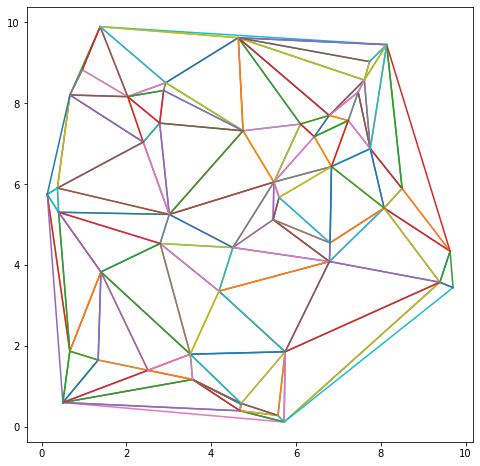

In [68]:
for tr in tg:
    p1, p2, p3 = tr
    
    p1x, p1y = p1
    p2x, p2y = p2
    p3x, p3y = p3
    
    plt.plot([p1x, p2x], [p1y, p2y])
    plt.plot([p1x, p3x], [p1y, p3y])
    plt.plot([p2x, p3x], [p2y, p3y])